In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

import scipy.fftpack as sfft
import random
import imageio
import sys
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
### 1920 x 1200 SLM
### pixel values range from 0-> 255, corresponding to a 0->2pi phase shift.

In [7]:
### Create diffraction grating
precision = 3 ### Multiplier to get better tunability
blank = np.empty((1920*precision,1920*precision),dtype=float)
grating = blank.copy()
width_pix = 8 ### choose this to be over 8, ideally
length_pix = 8 ### choose this to be over 8, ideally
numcols = np.size(grating[0])  ## should be 1920
numrows = np.size(grating[...,0])  ## should be 1200
max_iter = 50 ### for GS algo

### Settings for image generation
numframes = 30 # set number of frames in movie
min_width_pix = 8
min_length_pix = 8
stepsize_width_pix = 1 # must be integer
stepsize_length_pix = 1 # must be integer


def Ger_Sax_algo(InputImg, width, height, max_iter):
    TwoDImg = np.reshape(InputImg, (-1, width))

    pm_s = np.random.rand(height, width)
    pm_f = np.ones((height, width))
    am_s = np.sqrt(TwoDImg) / 2
    am_f = np.ones((height, width))

    signal_s = am_s*np.exp(pm_s * 1j)

    for iter in range(max_iter):
        signal_f = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(signal_s)))
        pm_f = np.angle(signal_f)
        signal_f = am_f*np.exp(pm_f * 1j)
        signal_s = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(signal_f)))
        pm_s = np.angle(signal_s)
        signal_s = am_s*np.exp(pm_s * 1j)
        
    phase_mask = np.uint8(((pm_f/(2*np.pi))*256)+128)  
    ### flat_phase = phase_mask.flatten()

    return phase_mask

### SLM Direct Images
# Create an SLM grating with sinusoidal pixel values
def calc_sinusoidal_grating(width, pixcoord_col):
    pixcoord = pixcoord_col % width
    phasemask = ((np.exp(1j*(2*np.pi/width)*pixcoord))+1)*256/2
    return np.real(phasemask)

def sinusoidal_grating(width):
    sinusoidalgrating = blank.copy()
    for i in range(0,numcols):
        temp_phase = calc_sinusoidal_grating(width, i)
        for j in range(0,numrows):
            sinusoidalgrating[j,i] = temp_phase
    return sinusoidalgrating

def calc_dblazed_grating(width, pixcoord_col):
    pixcoord = width - pixcoord_col % width
    phasemask = pixcoord * 255/width
    return np.real(phasemask)

def dblazed_grating(width):
    sinusoidalgrating = blank.copy()
    for i in range(0,numcols):
        temp_phase = calc_dblazed_grating(width, i)
        for j in range(0,numrows):
            sinusoidalgrating[j,i] = temp_phase
    return sinusoidalgrating

def calc_blazed_grating(width, pixcoord_col):
    pixcoord = pixcoord_col % width
    phasemask = pixcoord * 255/width
    return np.real(phasemask)

def blazed_grating(width):
    sinusoidalgrating = blank.copy()
    for i in range(0,numcols):
        temp_phase = calc_blazed_grating(width, i)
        for j in range(0,numrows):
            sinusoidalgrating[j,i] = temp_phase
    return sinusoidalgrating

def calc_sinusoidal2D_grating(width, length, pixcoord_row, pixcoord_col):
    pixcol = (pixcoord_col % width)
    pixrow = (pixcoord_row % width)
    pixvalcol = ((np.exp(1j*(2*np.pi/width)*pixcol))+1)*256/2
    pixvalrow = ((np.exp(1j*(2*np.pi/width)*pixrow))+1)*256/2
    return np.real(pixvalrow + pixvalcol) /2

def sinusoidal2D_grating(width, length):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        for j in range(0,numrows):
            temp_phase = calc_sinusoidal2D_grating(width, length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

# Create an SLM grating with linear pixel values - *Should* create the true diffraction grating A(x) we want.
def calc_simple_grating(width, pixcoord_col):
    pixcoord = (pixcoord_col % width)
    pixval = abs(256*2/(width)*pixcoord -256)
    return pixval

def simple_grating(width):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        temp_phase = calc_simple_grating(width,i)
        for j in range(0,numrows):
            simplegrating[j,i] = temp_phase
    return simplegrating

def calc_simple2D_grating(width, length, pixcoord_row, pixcoord_col):
    pixcol = (pixcoord_col % width)
    pixrow = (pixcoord_row % width)
    pixvalcol = abs(256*2/(width)*pixcol -256)
    pixvalrow = abs(256*2/(length)*pixrow -256)
    return (pixvalrow + pixvalcol) /2

def simple2D_grating(width, length):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        for j in range(0,numrows):
            temp_phase = calc_simple2D_grating(width, length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

### SLM Desired Fourier Plane Images
# Create an SLM 2-D Grating

def calc_coarse_grating(width, pixcoord_col):
    pixcoord = 0
    if pixcoord_col % width == 0:
        pixcoord = 255
    return pixcoord

def coarse_grating(width):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        temp_phase = calc_simple_grating(width,i)
        for j in range(0,numrows):
            simplegrating[j,i] = temp_phase
    return simplegrating

def calc_coarse2D_grating(width, length, pixcoord_row, pixcoord_col):
    pixcoord = 0
    if pixcoord_col % width == 0:
        pixcoord = 255
    if pixcoord_row % length == 0:
        pixcoord = 255
    return pixcoord

def coarse2D_grating(width, length):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        for j in range(0,numrows):
            temp_phase = calc_coarse2D_grating(width, length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

def coarse2D_grating_centered(width, length, xmin, xmax, ymin,ymax):
    simplegrating = np.zeros(np.shape(blank))
    for i in range(xmin,xmax):
        for j in range(ymin,ymax):
            temp_phase = calc_coarse2D_grating(width, length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

def calc_dotted2D_grating(width, length, pixcoord_row, pixcoord_col):
    pixcoord = 0
    if (pixcoord_col % width == 0) and (pixcoord_row % length == 0):
        pixcoord = 255
    return pixcoord

def dotted2D_grating(width, length):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        for j in range(0,numrows):
            temp_phase = calc_dotted2D_grating(width, length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

def dotted2D_grating_centered(width, length, xmin, xmax, ymin,ymax):
    simplegrating = np.zeros(np.shape(blank))
    for i in range(xmin,xmax):
        for j in range(ymin,ymax):
            temp_phase = calc_dotted2D_grating(width, length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

def calc_square_center(width, length, pixcoord_row, pixcoord_col):
    pixcoord = 0
    centercol = int(numcols/2)
    centerrow = int(numrows/2)
    if (abs(pixcoord_row-centerrow) == width):
        pixcoord = 255
    if (abs(pixcoord_col-centercol) == length):
        pixcoord = 255
    return pixcoord

def square_center_grating(width,length):
    simplegrating = blank.copy()
    for i in range(0,numcols):
        for j in range(0,numrows):
            temp_phase = calc_square_center(width,length, j, i)
            simplegrating[j,i] = temp_phase
    return simplegrating

def f_grating(pattern):
    return Ger_Sax_algo(pattern, numcols, numrows, max_iter)




### Image writing!

def writeimg(array, name):
    data = Image.fromarray(array).convert('RGB')
    data.save(name+".bmp")
    return print(name+" saved succesfully.")

def print_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        writeimg(array, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        writeimg(array, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")

def print_f_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_f_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")
        
        
def slm_2D_simulator(function, maxiter, min_width_pix, min_length_pix):
    slmarray = function(min_width_pix, min_length_pix)
    slmimage = Ger_Sax_algo(slmarray, numcols, numrows, maxiter)
    fourierimage = np.abs(np.fft.fft2(slmimage))
    fourierimage = fourierimage/np.max(fourierimage)*255
    writeimg(fourierimage,"simulim")
    return print("Print successful")
    

In [8]:
init_im = coarse2D_grating_centered(15, 15, 385, 2135, 785, 3135)
target = writeimg(init_im, "array30off")

array30off saved succesfully.


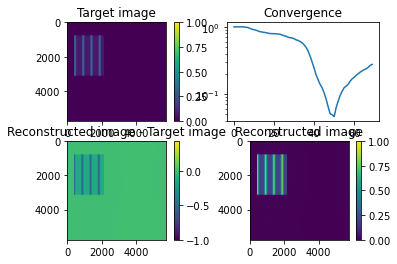

In [9]:
### Testing Ger-Sax algorithm

def epsilon(u_int, target_im):
    max = np.max(u_int[target_im==1]) #Max value of the obtained intensity at the tweezers position
    min = np.min(u_int[target_im==1]) #Min value of the obtained intensity at the tweezers position
    error = (max-min)/(max+min)
    #print("Error :", error)
    return error

def join_phase_ampl(phase,ampl):
    tmp=np.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = ampl*np.exp(phase*1j)
    return tmp

def Beam_shape(sizex,sizey,sigma,mu):
    x, y = np.meshgrid(np.linspace(-1,1,sizex), np.linspace(-1,1,sizey))
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return g

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

def norm(matrix):
    min=np.min(matrix);max=np.max(matrix)
    return((matrix-min)/(max-min))

def bin_norm_clip(matrix):  # Function that clips the values to 0-255 (SLM standard)
    matrix=np.array(target_im, dtype=np.uint8)
    matrix=norm(matrix)
    return(matrix)


def weights(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    w[target_im==1] = np.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    return (w)

def discretize_phase(phase):
    phase=np.round((phase+np.pi)*255/(2*np.pi))
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*np.pi)-np.pi
    return(phase)


target_im = np.asarray(Image.open("array30off.bmp"))
newtar = np.zeros((1920*precision,1920*precision))
for i in range(1920*precision):
  for j in range(1920*precision):
    newtar[i,j] = target_im[i,j,1]
target_im = norm(newtar)

SIZE_X, SIZE_Y = 1920, 1920
fig, axs = plt.subplots(2,2)
im0=axs[0,0].imshow(target_im)
plt.colorbar(im0,ax=axs[0,0])
axs[0,0].set_title('Target image')


# The initial weights are all = 1.
n_rep = 70
w=np.ones((SIZE_X*precision,SIZE_Y*precision))
# The amplitude in the fourier plane is a Gaussian (beam)
PS_shape=Beam_shape(SIZE_X,SIZE_Y,255,0)
w_prev=target_im

errors=[]
u=np.zeros((SIZE_X,SIZE_Y),dtype=complex)
phase=2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi

for rep in range(n_rep):
    # Fourier plane, random phase (at the round 1) and gaussian beam
    u=join_phase_ampl(phase,PS_shape.T)
        # To the real plane...
    u = sfft.fft2(u)
    u = sfft.fftshift(u)
    uscaled =np.repeat(np.repeat(u, precision, axis=0), precision, axis=1)
    # Calculate the intensity
    int=np.square(np.abs(uscaled))
    # Let's renormalize the intensity in the range [0,1]
    std_int=norm(int)
    # What's the distance from the target intensity?
    errors.append(epsilon(std_int, target_im))
    phase=np.angle(uscaled)
    ## Here I don't care about the discretization of the phase because we're in real space (that is actually the fourier plane for the code)
    #Generate weights and use them to obtain u
    w=weights(w,target_im,w_prev,std_int)
    w=norm(w)
    w_prev=w
    uscaled=join_phase_ampl(phase,w)
    # Back to our fourier plane
    reshape_u = uscaled.reshape(1920,precision,1920,precision)
    u = np.mean(reshape_u, axis=(-3,-1))
    u = sfft.ifftshift(u)
    u = sfft.ifft2(u)

    # The phase that we need to imprint by the SLM is :
    phase=np.angle(u)
    # This part discretizes the values of phase. The SLM can only produce values in the range [0,255]
    # that corresponds to [0,2pi]. Some values (e.g. 0.5 => 0.5 * 2pi/255) cannot be reproduced by the SLM
    # This discretization takes that in account. (The final phase will be the discretized one)
    phase=discretize_phase(phase)
    Final_ampl_phase=phase
    phase=undiscretize_phase(phase)

axs[0,1].plot(errors)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Convergence')


im1=axs[1,0].imshow(target_im-std_int)
plt.colorbar(im1,ax=axs[1,0])
axs[1,0].set_title('Reconstructed image - Target image')

im2=axs[1,1].imshow(std_int)
plt.colorbar(im2,ax=axs[1,1])
axs[1,1].set_title('Reconstructed image')
plt.show()

In [10]:
writeimg(Final_ampl_phase, "gws15pixoff")

gws15pixoff saved succesfully.


In [11]:
img = Image.open('gws15pixoff.bmp')
img = np.asarray(img)
blank = img[:,:,0]
blank = np.exp(1j * blank * 2 * np.pi / 256)
maxval = np.amax(blank)
f = np.fft.fftshift(np.fft.fft2(blank))
mag_spectrum = np.abs(f)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

In [12]:
data = Image.fromarray(scaledimg).convert('RGB')
data.save("Simulationgws15pixoff.bmp")